In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

from statsforecast.models import AutoARIMA
import scipy.stats as stats

plt.style.use('fast')

%matplotlib inline

In [172]:
train_data = pd.read_csv(r'DailyDelhiClimateTrain.csv', parse_dates=['date'])
test_data = pd.read_csv(r'DailyDelhiClimateTest.csv', parse_dates=['date'])

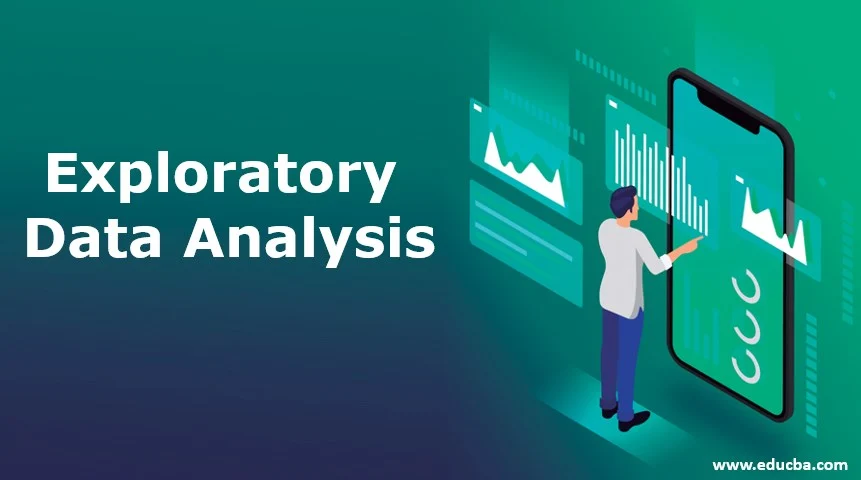

In [173]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [174]:
train_data.describe()

date     meantemp     humidity   wind_speed  \
count                 1462  1462.000000  1462.000000  1462.000000   
mean   2015-01-01 12:00:00    25.495521    60.771702     6.802209   
min    2013-01-01 00:00:00     6.000000    13.428571     0.000000   
25%    2014-01-01 06:00:00    18.857143    50.375000     3.475000   
50%    2015-01-01 12:00:00    27.714286    62.625000     6.221667   
75%    2016-01-01 18:00:00    31.305804    72.218750     9.238235   
max    2017-01-01 00:00:00    38.714286   100.000000    42.220000   
std                    NaN     7.348103    16.769652     4.561602   

       meanpressure  
count   1462.000000  
mean    1011.104548  
min       -3.041667  
25%     1001.580357  
50%     1008.563492  
75%     1014.944901  
max     7679.333333  
std      180.231668

In [175]:
train_data = train_data.iloc[:-1]
train_data.set_index('date', inplace=True)

train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month
train_data['Day'] = train_data.index.day

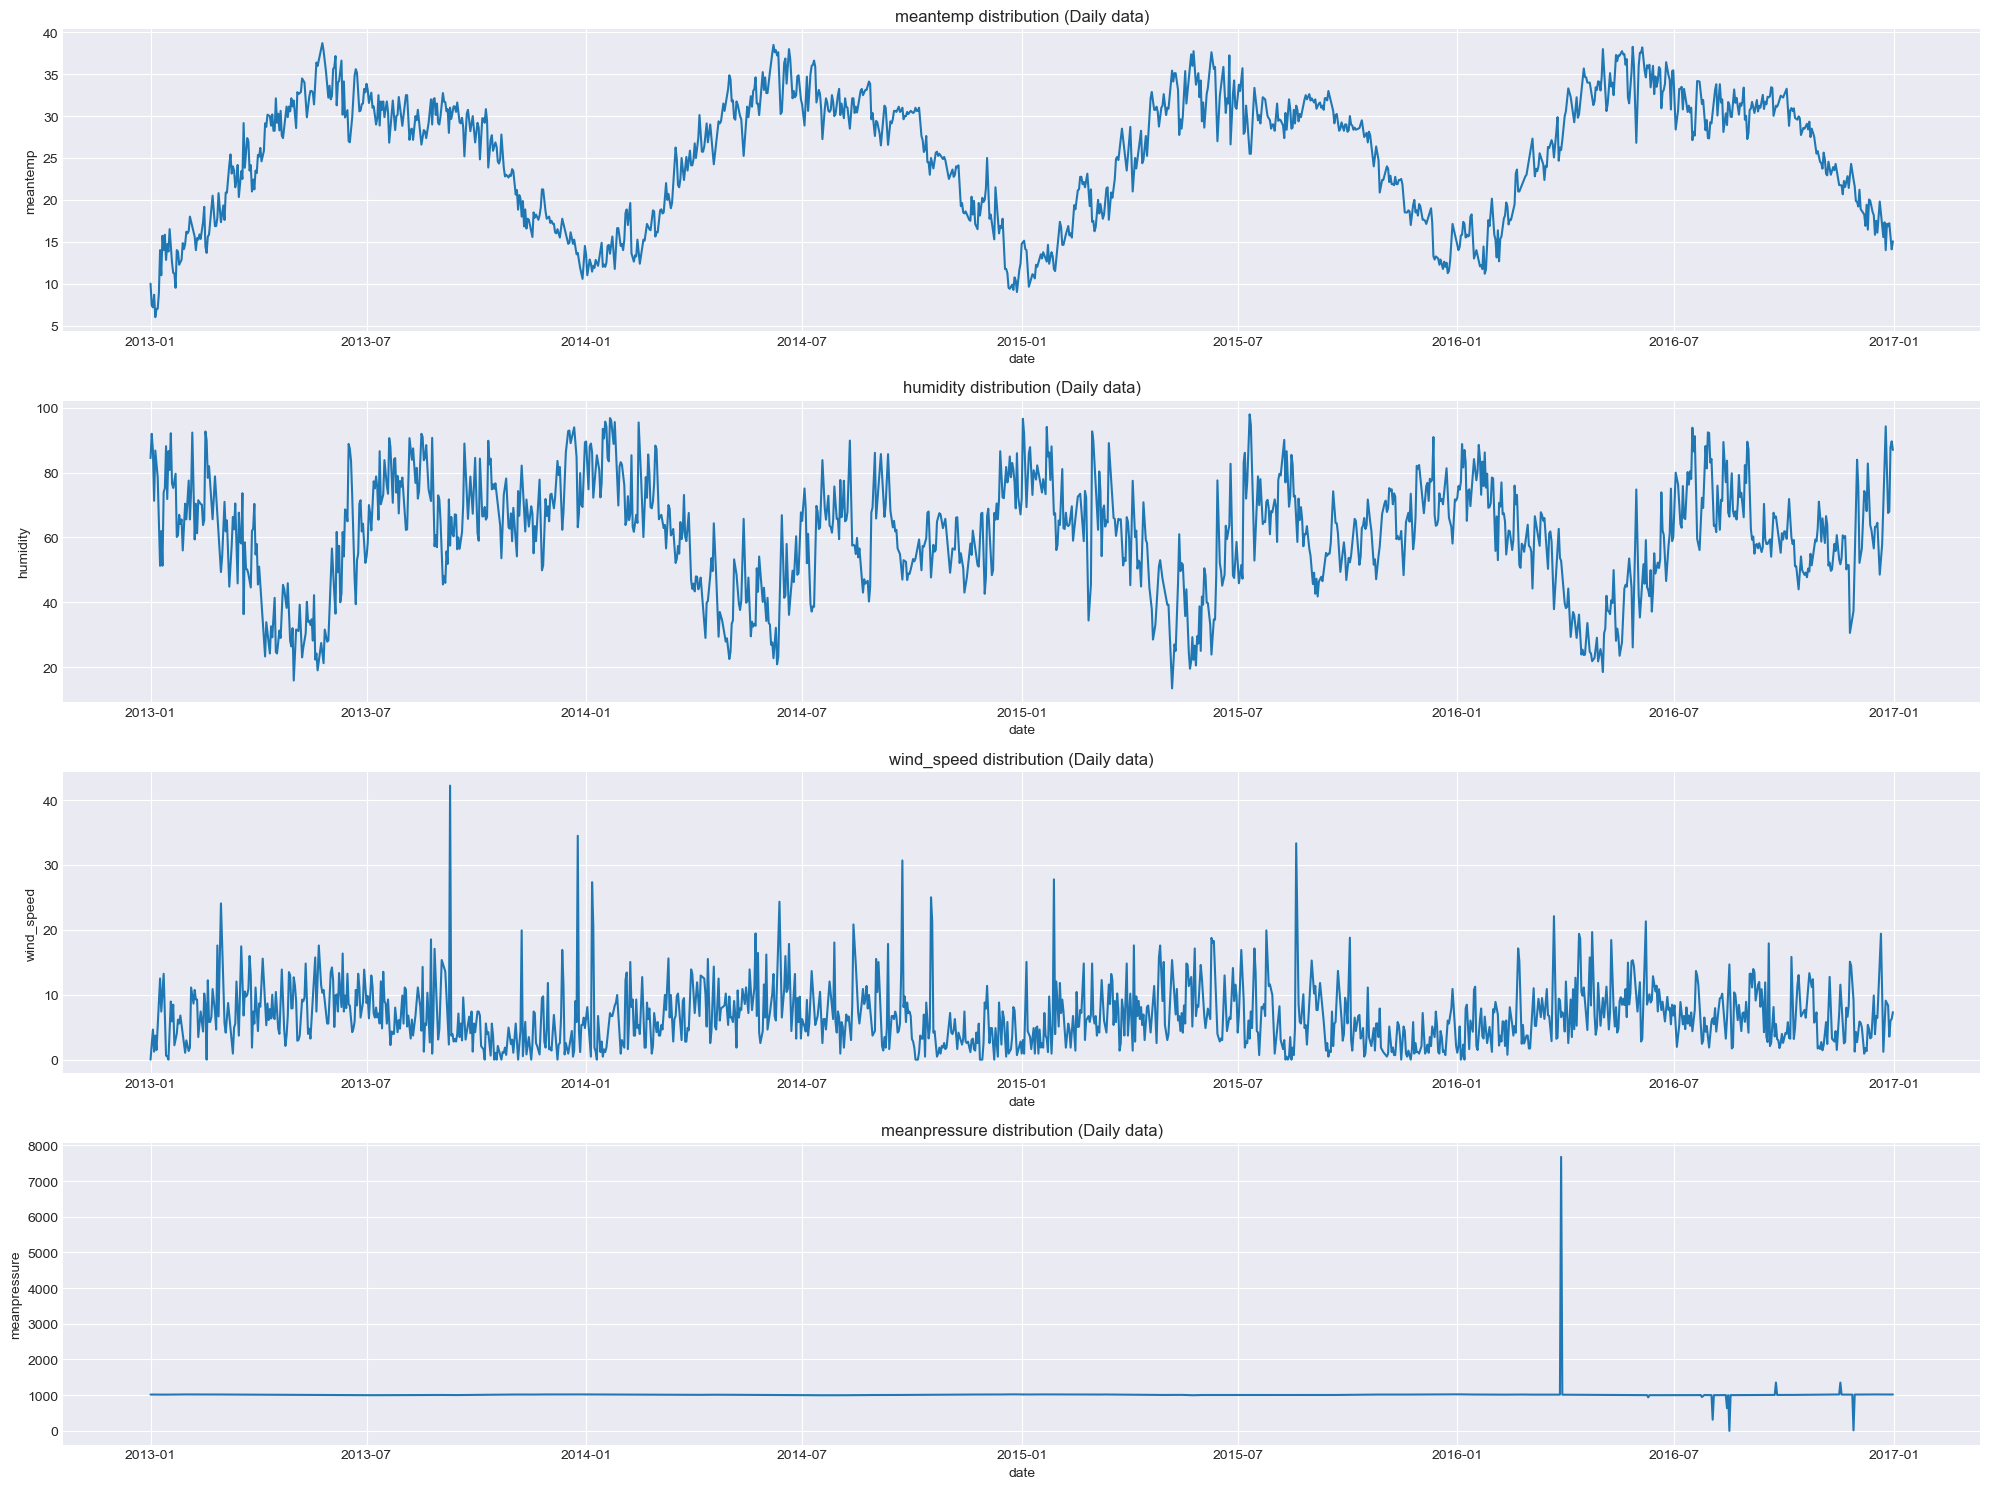

In [176]:
cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

fig, axes = plt.subplots(figsize=(20, 15), nrows=4)

for ax, col in zip(axes, cols):

    sns.lineplot(ax=ax, data=train_data, x='date', y=col)

    ax.set_title(f"{col} distribution (Daily data)")
    ax.grid(True)

plt.tight_layout()
plt.show()

#### meantemp has yearly seasonality
#### humidity seems to be cyclic
#### windspeed seems to also underline some kind of trend

In [177]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomposition(data, col):

    add_seasonal_dec = seasonal_decompose(data[col], model='additive', period=365)

    fig1 = add_seasonal_dec.plot()
    fig1.suptitle("Additive Decomposition")
    fig1.set_size_inches((20,10))

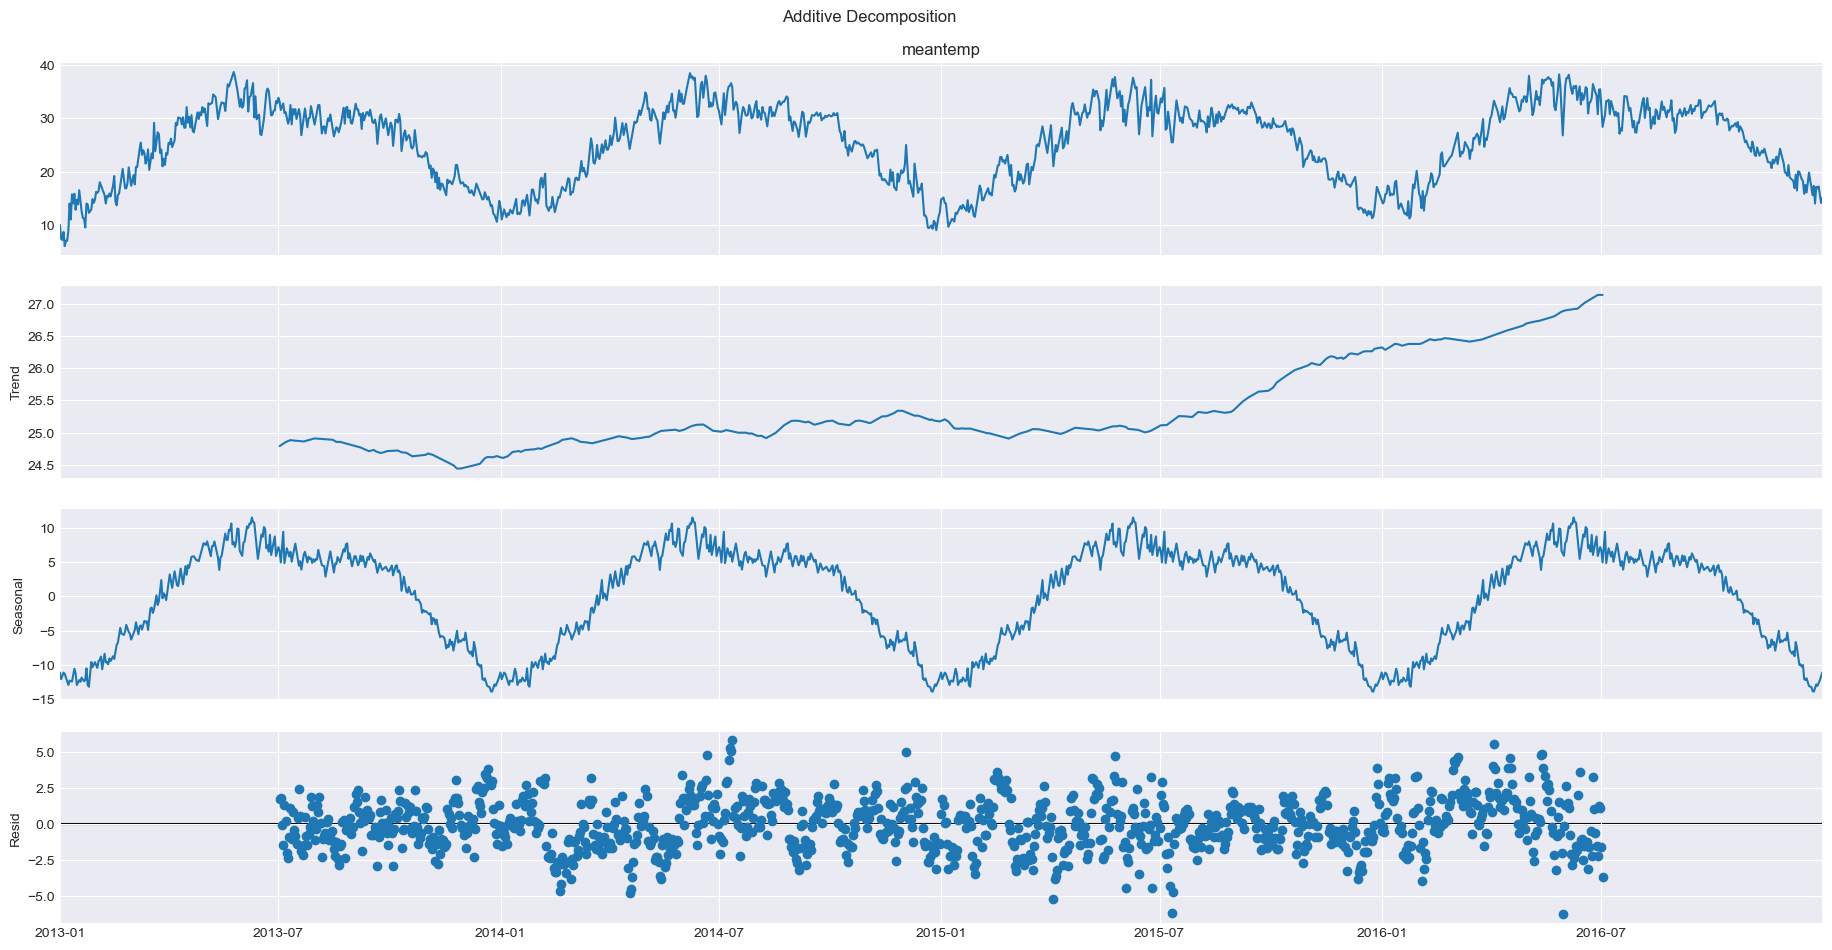

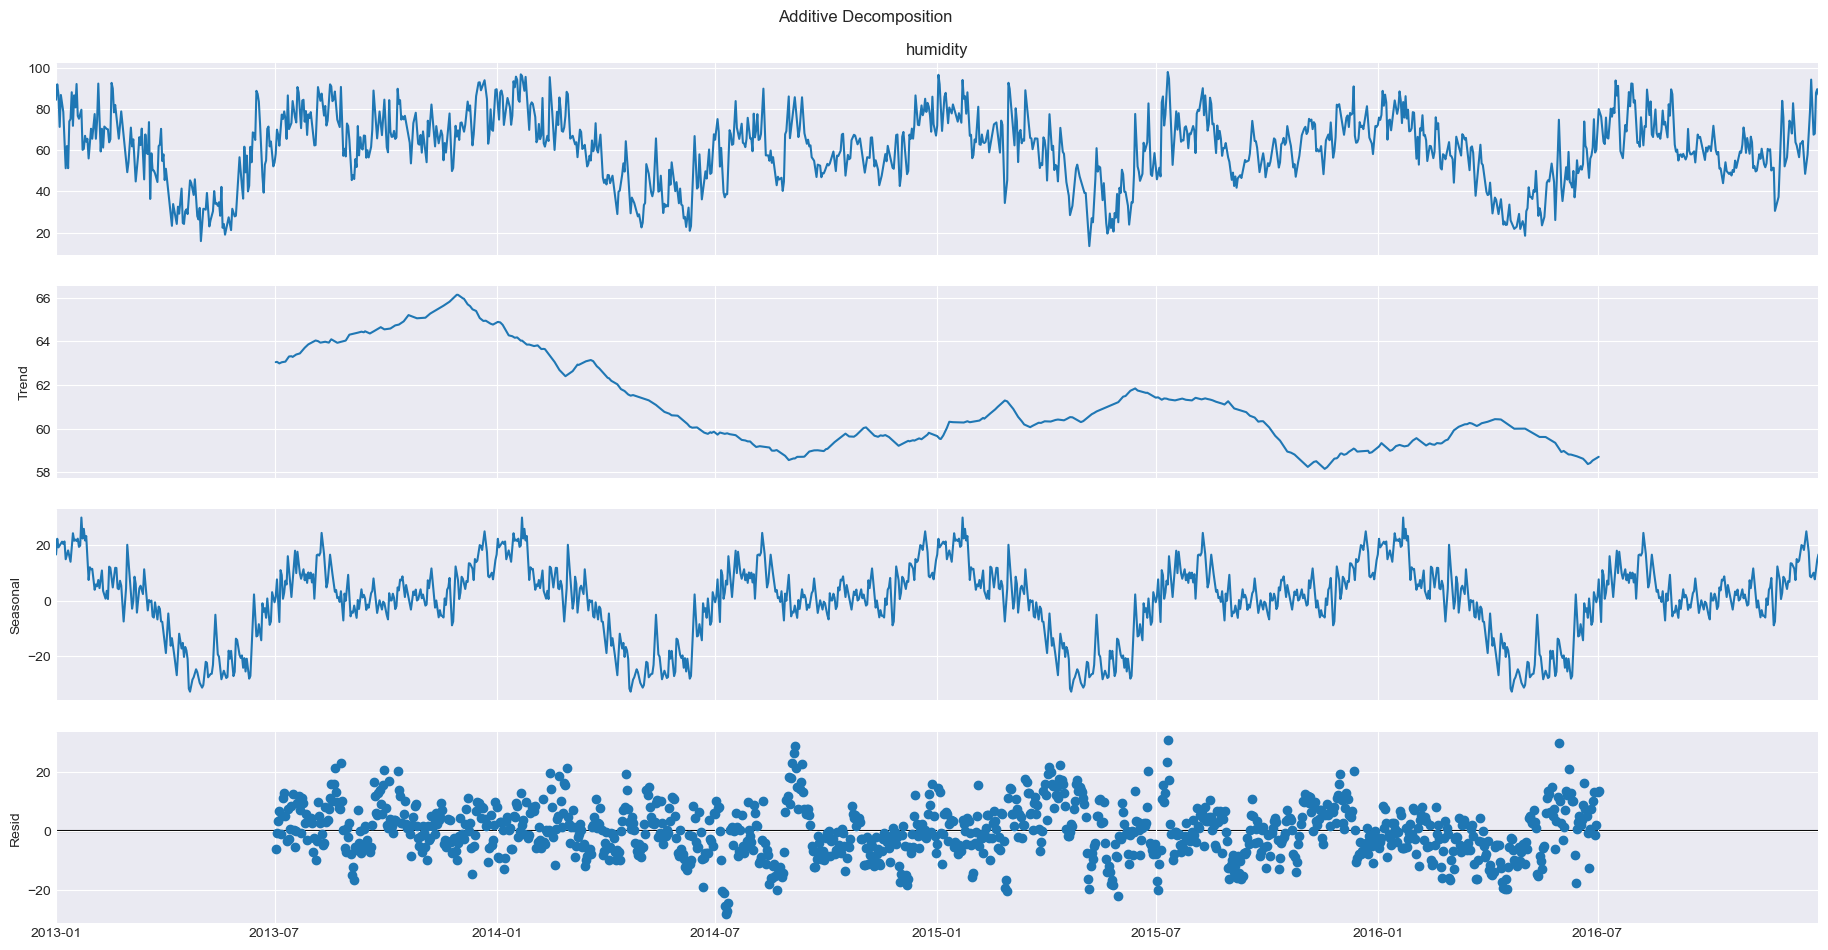

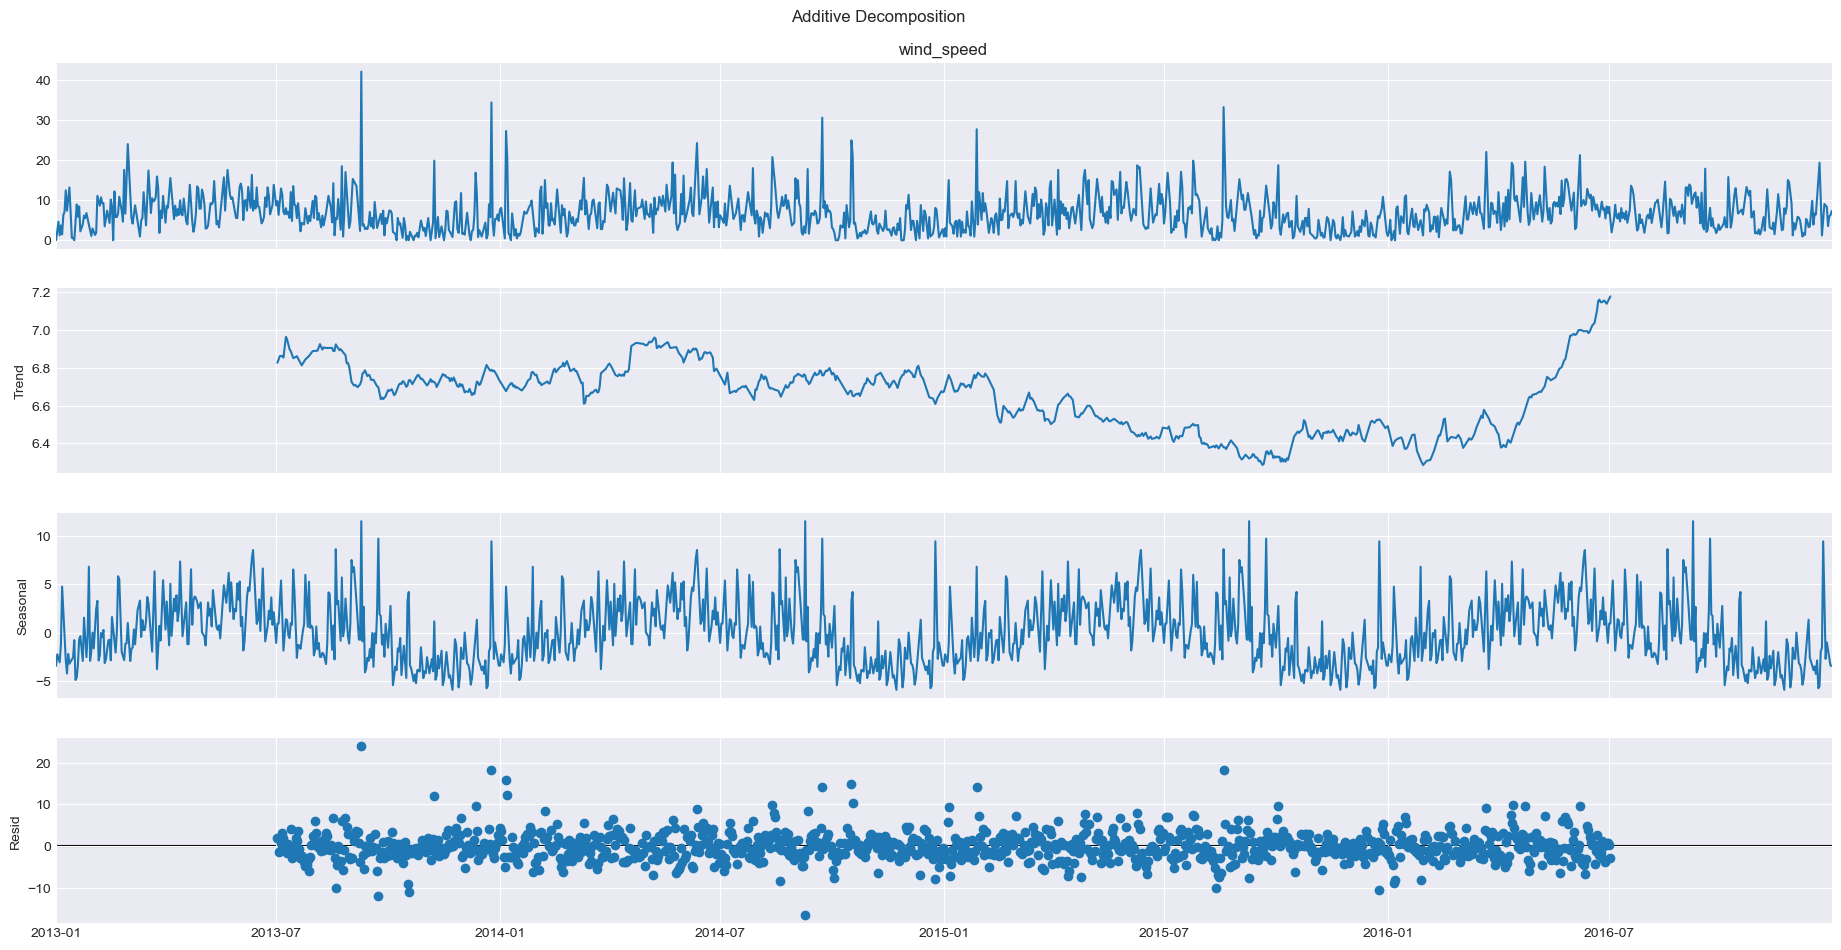

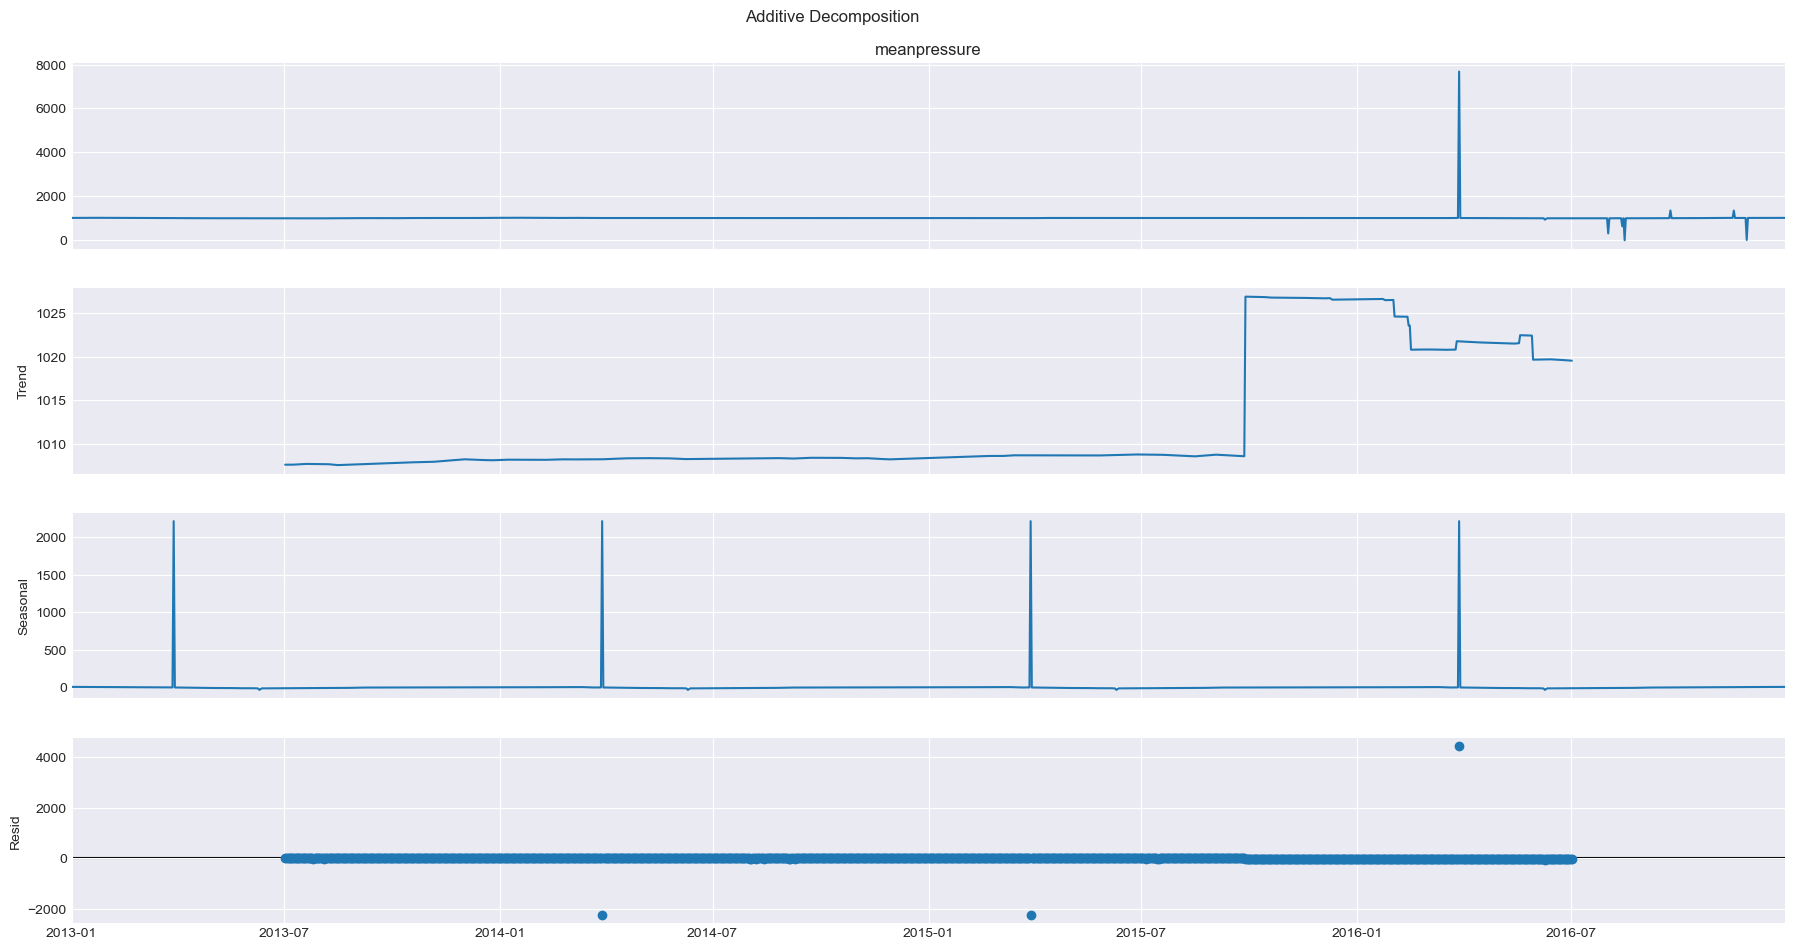

In [178]:
for col in cols:
    seasonal_decomposition(train_data, col)

#### ^^ meanpressure can be probably dropped, we will delve into it later on

### AVG feature distribution (MoM)

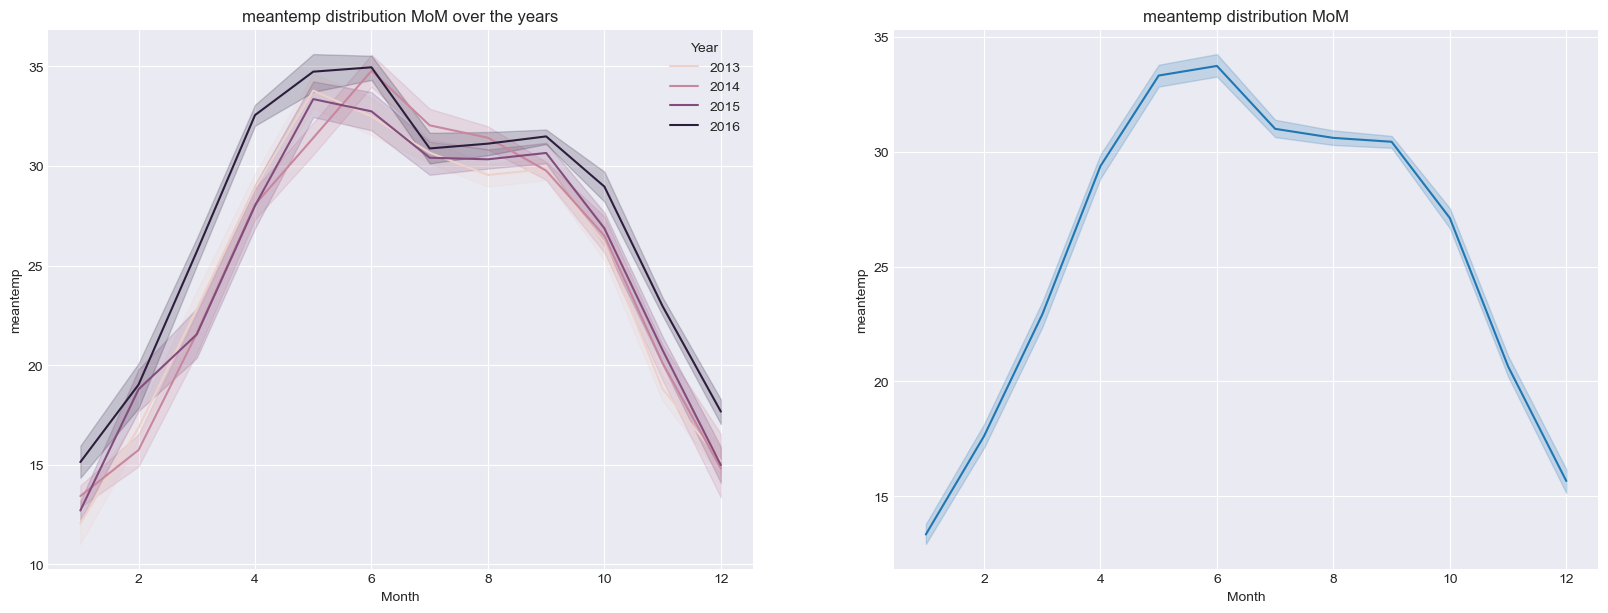

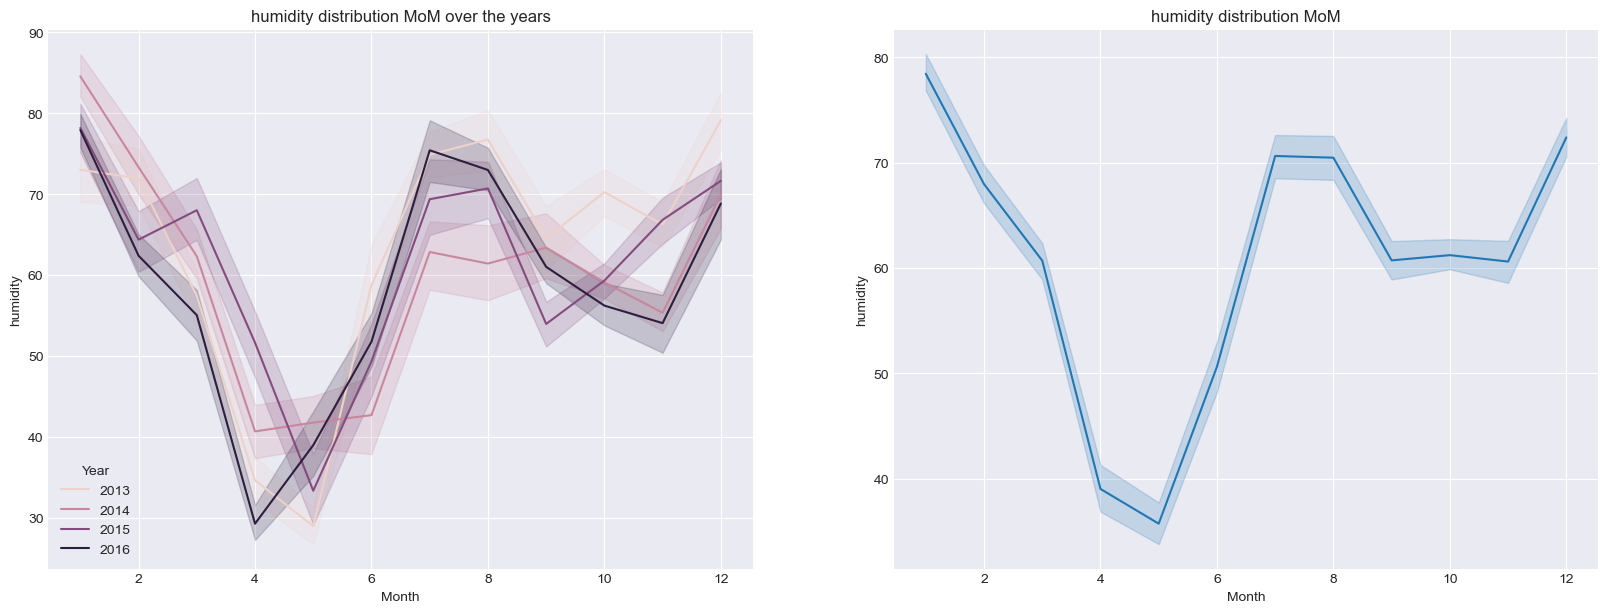

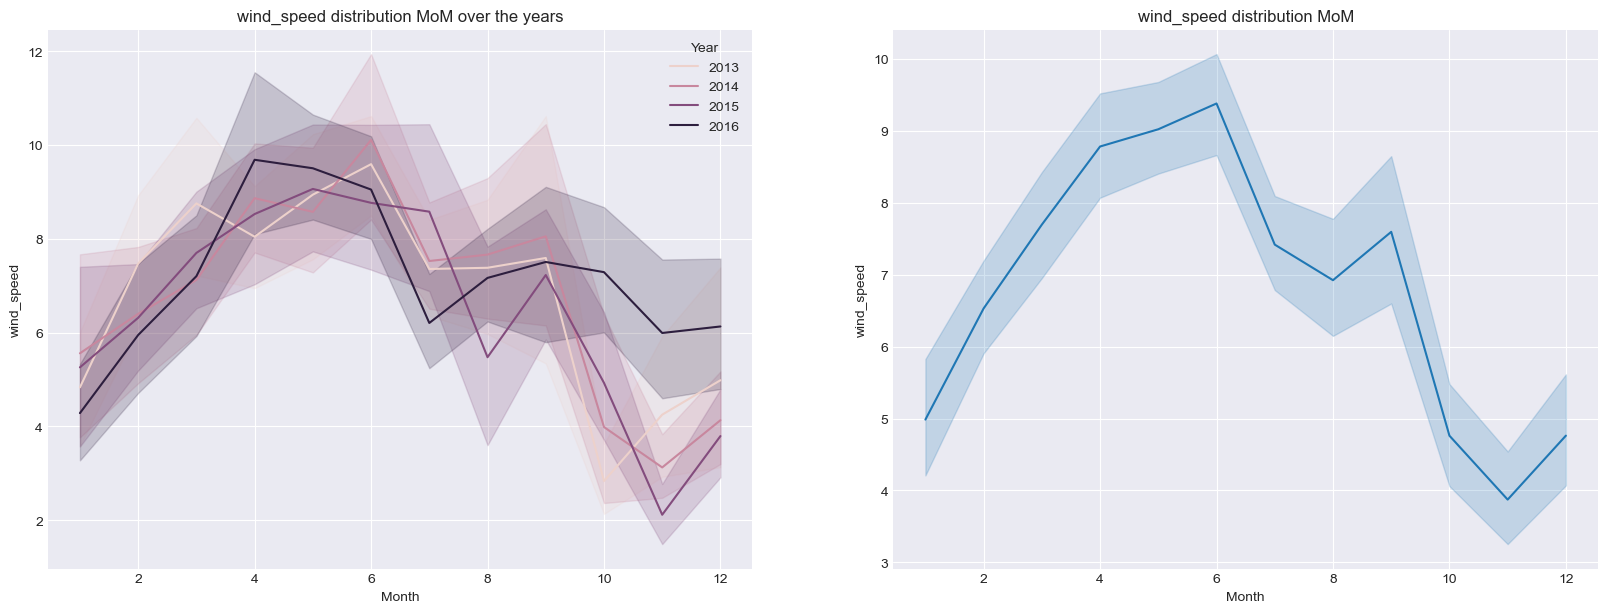

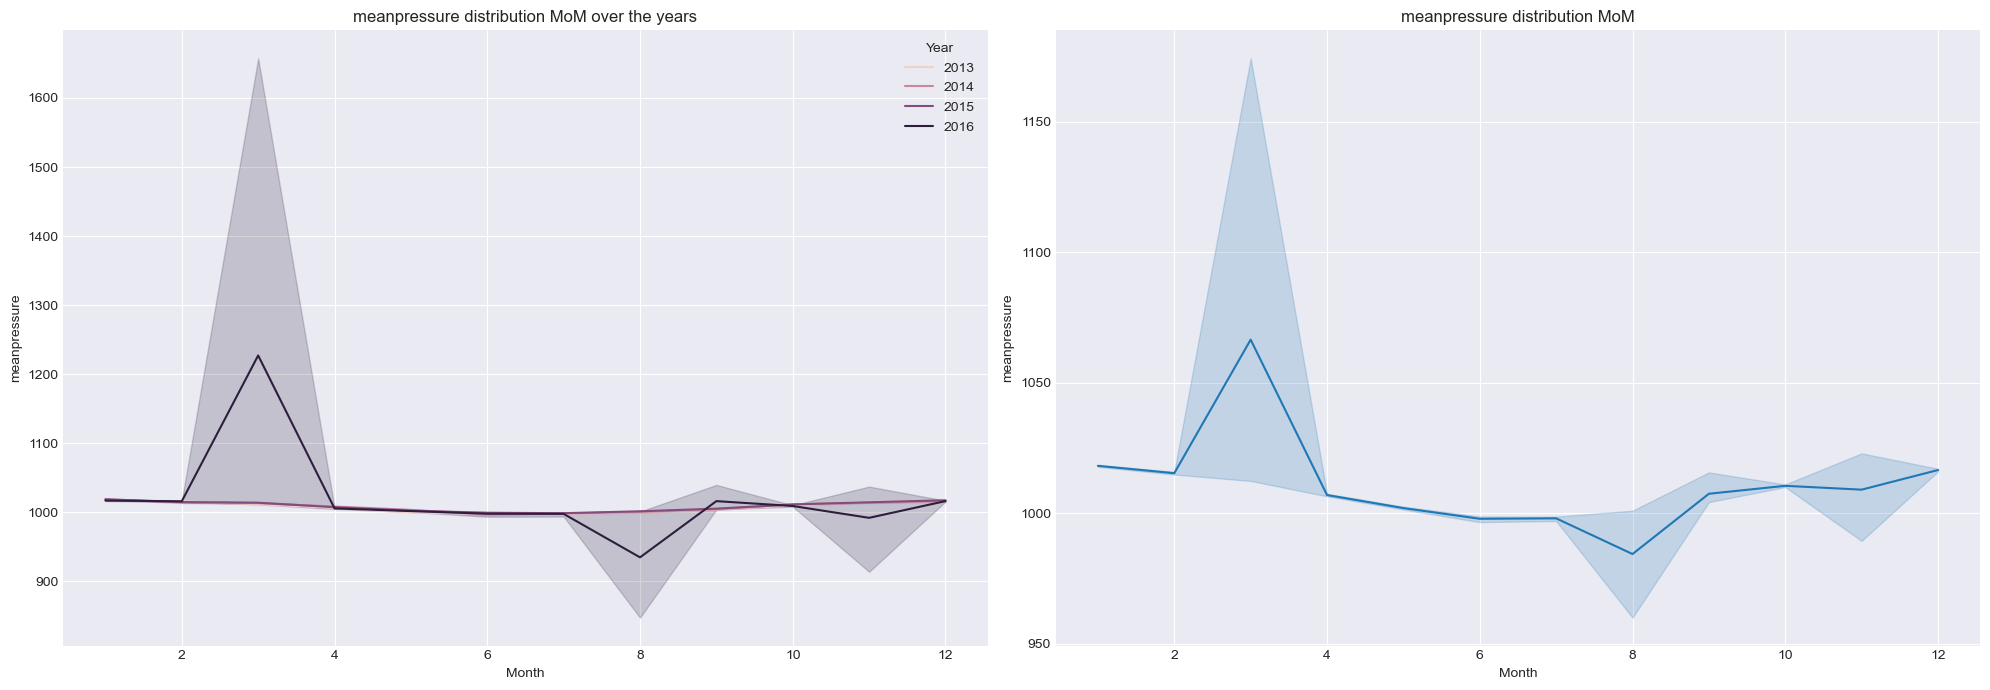

In [179]:
for col in cols:
    fig, axes = plt.subplots(figsize=(20,7), nrows=1, ncols=2)

    sns.lineplot(ax=axes[0], data=train_data, x='Month', y=col, hue='Year')
    axes[0].set_title(f'{col} distribution MoM over the years')
    axes[0].grid(True)

    sns.lineplot(ax=axes[1], data=train_data, x='Month', y=col)
    axes[1].set_title(f'{col} distribution MoM')
    axes[1].grid(True)

plt.tight_layout()
plt.show()

#### ^^ Similarly, meanpressure appears largely uninformative and exhibits excessive variability during specific periods.

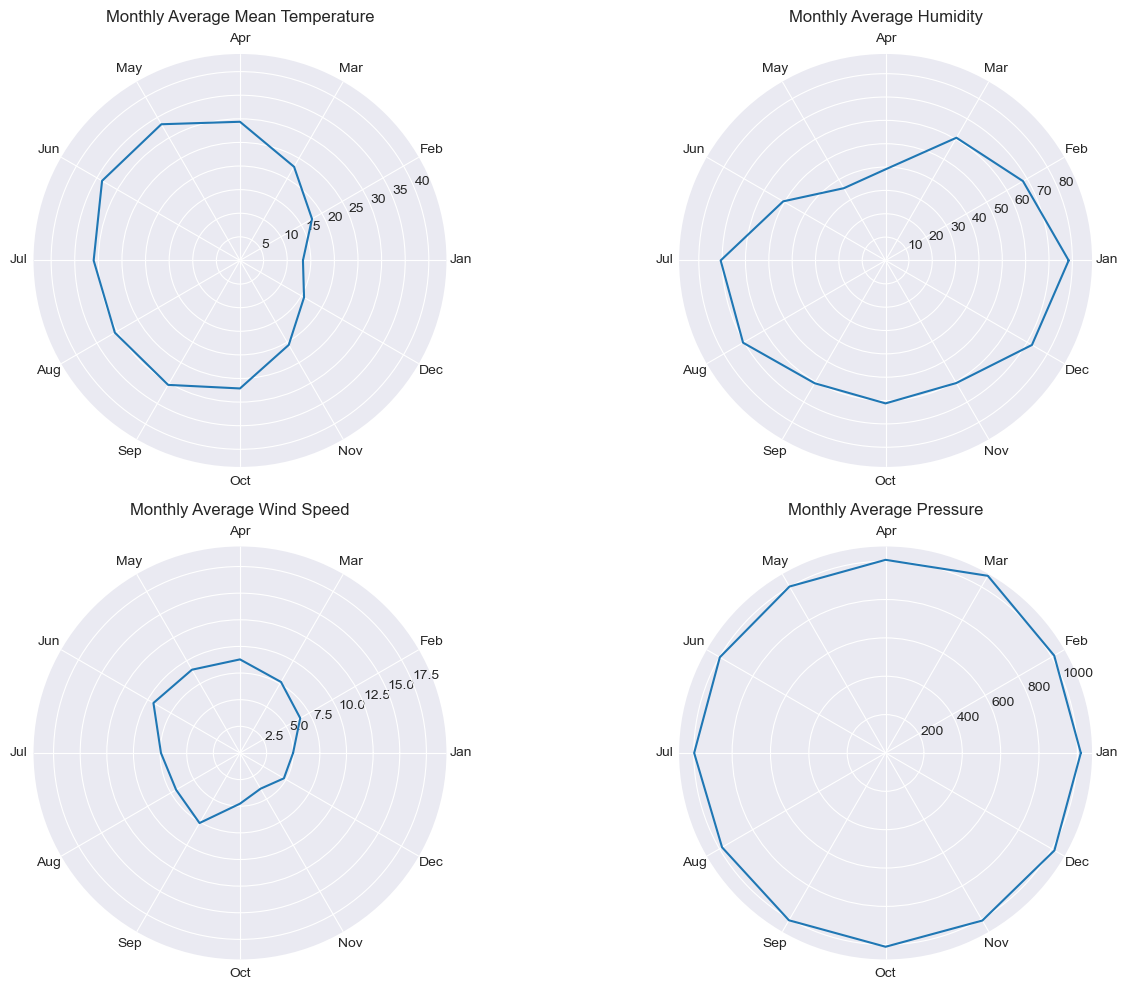

In [180]:
sns.set_style('darkgrid')

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 10))

parameters = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

titles = ['Monthly Average Mean Temperature', 'Monthly Average Humidity', 
        'Monthly Average Wind Speed', 'Monthly Average Pressure']


for ax, param, title in zip(axs.flatten(), parameters, titles):

    monthly_avg = train_data.groupby(by='Month')[param].mean()

    theta = np.linspace(0, 2 * np.pi, len(monthly_avg), endpoint=False) 
    radii = monthly_avg.values 

    theta = np.append(theta, theta[0])
    radii = np.append(radii, radii[0])
    
    ax.plot(theta, radii)
    ax.set_title(title, va='bottom')
    ax.set_xticks(theta[:-1])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                        'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    ax.set_ylim(0, radii.max() + 10)
    

plt.tight_layout()
plt.show()

#### <span style="color: red"> Avg pressure is always the same, not that informative -> drop from df before any further step </span>

In [181]:
train_data_features_selected = train_data[['meantemp', 'humidity', 'wind_speed']]

## Check stationarity

In [182]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### ACF/PACF before differencing

In [183]:
acf_plot = plot_acf(train_data_features_selected['meantemp'], title='Autocorrelation for Mean Temperature')
acf_plot.set_size_inches((15,7))

pacf_plot = plot_pacf(train_data_features_selected['meantemp'], title='Partial Autocorrelation for Mean Temperature')
pacf_plot.set_size_inches((15,7))

#### the ACF underlines how the meantemp series is NOT stationary, let's check with KPSS and ADFF tests

In [184]:
from statsmodels.tsa.stattools import kpss, adfuller
from termcolor import colored

In [185]:
def kpss_adff_testing(df, col):

    print(colored(col, color='yellow', attrs=['bold']))

    kpss_stat, p_value, lags, crit = kpss(df[col])

    print("*" * 40, "KPSS Test", "*" * 40, "\n")

    print(f" KPSS: {kpss_stat},\n p_value: {p_value},\n lags: {lags},\n crit: {crit}\n")

    if p_value < 0.05:
        print(colored('The Series is NOT stationary - KPSS', color='red', attrs=['bold']))
    else:
        print(colored('The Series is Stationary - KPSS', color='green', attrs=['bold']))

    adff_stat, adff_pvalue, adff_lags, nobs, adff_crit, icbest = adfuller(df[col])

    print("*" * 40, "ADFF Test", "*" * 40, "\n")

    print(f" ADFF: {adff_stat},\n p_value: {adff_pvalue},\n lags: {adff_lags},\n nobs: {nobs},\n critical values: {adff_crit},\n icbest: {icbest}\n")

    if adff_pvalue > 0.05:
        print(colored('The Series is NOT stationary - ADFF', color='red', attrs=['bold']))
    else:
        print(colored('The Series is Stationary - ADFF', color='green', attrs=['bold']))

    print("=" * 40,"\n")

In [186]:
for col in train_data_features_selected:
    kpss_adff_testing(train_data_features_selected, col)

meantemp
**************************************** KPSS Test **************************************** 

 KPSS: 0.19176382197969408,
 p_value: 0.1,
 lags: 25,
 crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

The Series is Stationary - KPSS
**************************************** ADFF Test **************************************** 

 ADFF: -2.15556522744643,
 p_value: 0.2227659398673355,
 lags: 10,
 nobs: 1450,
 critical values: {'1%': -3.4348678719530934, '5%': -2.863535337271721, '10%': -2.5678323015457787},
 icbest: 5408.01809807777

The Series is NOT stationary - ADFF

humidity
**************************************** KPSS Test **************************************** 

 KPSS: 0.0940574137537446,
 p_value: 0.1,
 lags: 24,
 crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

The Series is Stationary - KPSS
**************************************** ADFF Test **************************************** 

 ADFF: -3.7375382997902213,
 p_value: 0.0036150791308486793,
 

## Forecast using weekly and monthly data

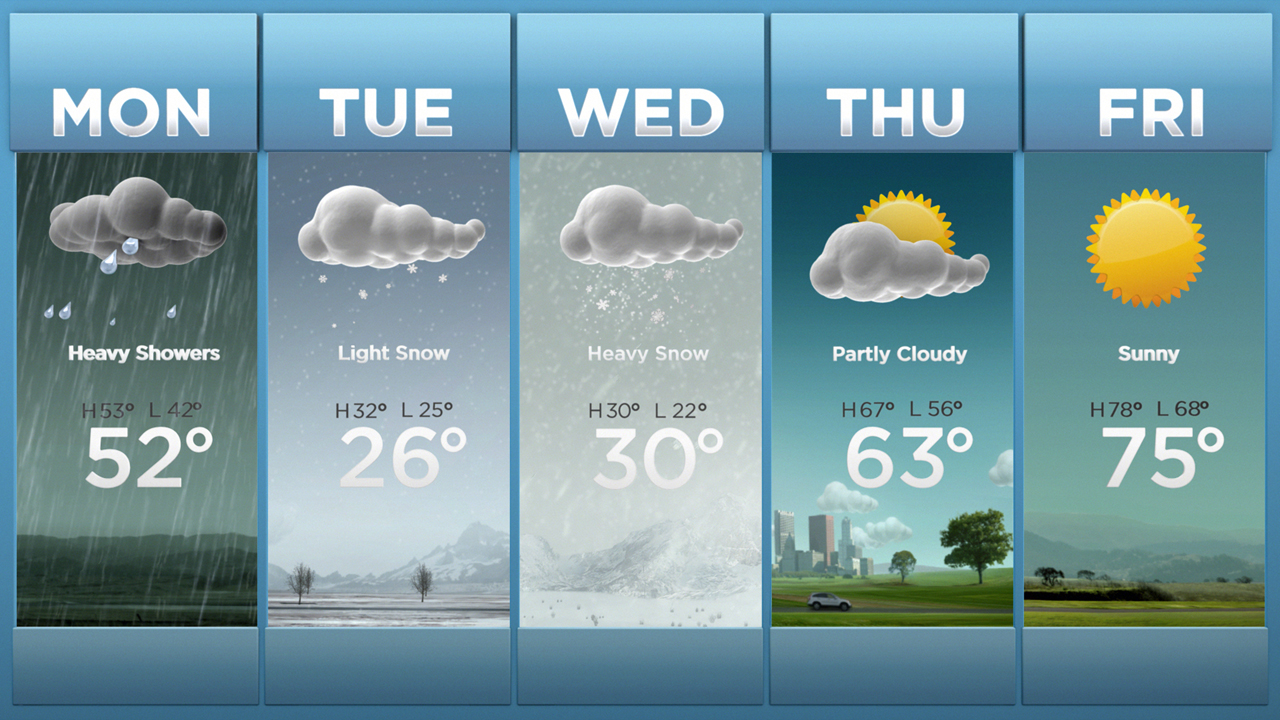

### Get, format and select feature from test data

In [187]:
test = deepcopy(test_data)
test.set_index('date', inplace=True)
test.drop(['meanpressure'], axis=1, inplace=True)

### Splitting in training/testing weekly and monthly data

In [188]:
train_weekly_data_grouped = train_data_features_selected.resample('W-MON').mean().rename(index={'date': 'Week'})
train_monthly_data_grouped = train_data_features_selected.resample('MS').mean().rename(index={'date': 'YM'})

test_monthly_data_grouped = test.resample('MS').mean().rename(index={'date': 'YM'})
test_weekly_data_grouped = test.resample('W-MON').mean().rename(index={'date': 'Week'})

### Differencing

In [189]:
def differencing(data):
    df_log_transformed = np.log1p(data)
    df_diff = df_log_transformed.diff().dropna()

    return df_diff     

In [190]:
differenced_train_weekly_data = differencing(train_weekly_data_grouped)
differenced_train_monthly_data = differencing(train_monthly_data_grouped)

differenced_test_weekly_data = differencing(test_weekly_data_grouped)
differenced_test_monthly_data = differencing(test_monthly_data_grouped)

In [191]:
def plot_acf_pacf(df_diff):
    """
    Plot non-seasonal and seasonal ACF/PACF for a differenced series.

    Parameters
    ----------
    df_diff : pd.DataFrame
        DataFrame containing log-transformed and first-differenced series.
    col : str
        Column name of the series to analyze (e.g., 'meantemp').
    D : int, default=1
        Order of seasonal differencing to apply.
    m : int, default=12
        Seasonal period (e.g., 12 for monthly data).
    """

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes = axes.flatten()

    plot_acf(df_diff['meantemp'], ax=axes[0], title='Non-seasonal ACF (d=1)')
    plot_pacf(df_diff['meantemp'], ax=axes[1], title='Non-seasonal PACF (d=1)')

    plt.tight_layout()
    plt.show()


    for col in df_diff:
        kpss_adff_testing(df_diff, col)

############

def check_stationarity(df_diff):

    fig = plt.figure(figsize=(15,5))
    sns.lineplot(df_diff)

    fig, axes = plt.subplots(nrows=3,figsize=(15,5))

    for ax, col in zip(axes, df_diff):
        sns.lineplot(ax=ax, data=df_diff, x=df_diff.index, y=col)
        ax.set_title(f'{col} differentiated distribution (no seasonality)')

    plt.tight_layout()
    plt.show()

    print("*"*25, colored("ACF & PACF GRAPHS", color='green', attrs=['bold']), "*"*25)

    plot_acf_pacf(df_diff)

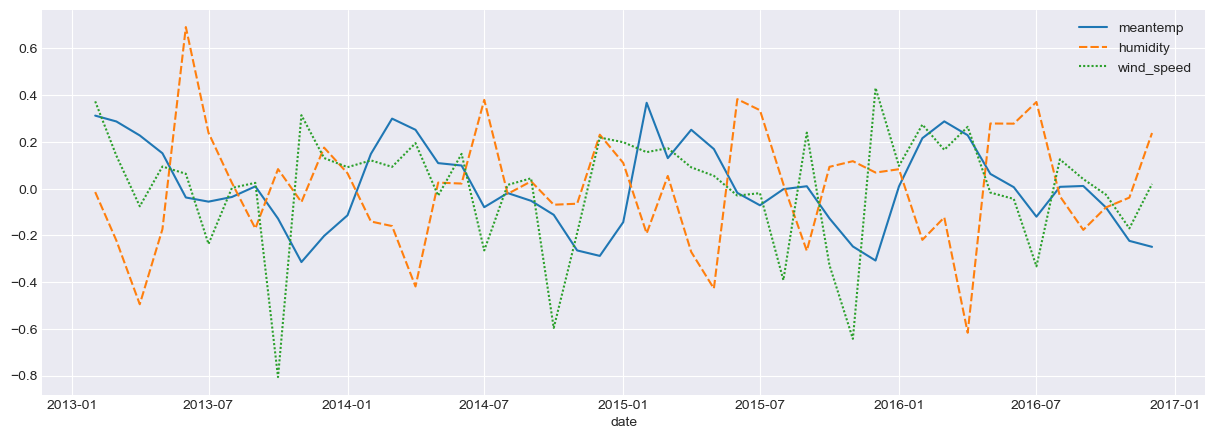

************************* ACF & PACF GRAPHS *************************


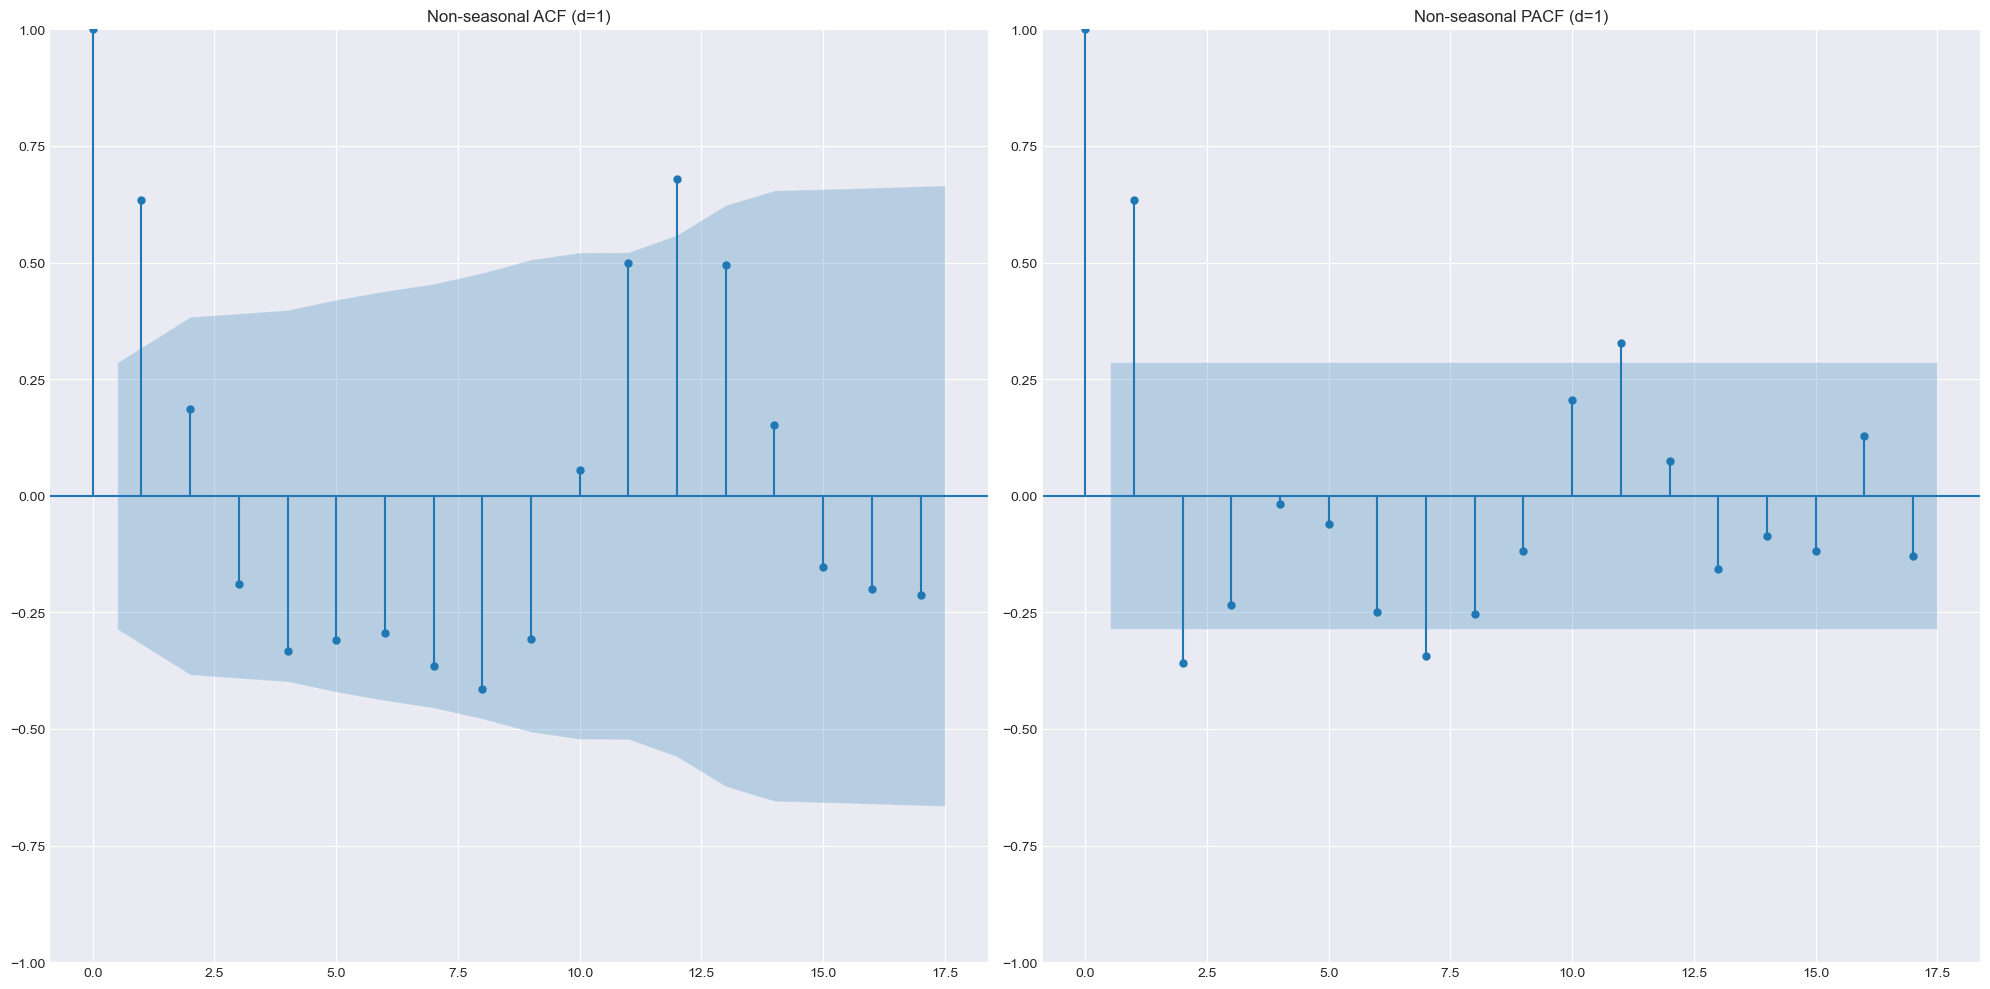

meantemp
**************************************** KPSS Test **************************************** 

 KPSS: 0.10455077117281115,
 p_value: 0.1,
 lags: 3,
 crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

The Series is Stationary - KPSS
**************************************** ADFF Test **************************************** 

 ADFF: -6.252996867270703,
 p_value: 4.407385171816269e-08,
 lags: 10,
 nobs: 36,
 critical values: {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383},
 icbest: -88.85440530215612

The Series is Stationary - ADFF

humidity
**************************************** KPSS Test **************************************** 

 KPSS: 0.06650797454498755,
 p_value: 0.1,
 lags: 4,
 crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

The Series is Stationary - KPSS
**************************************** ADFF Test **************************************** 

 ADFF: -6.811894145675314,
 p_value: 2.1059691910252898e-09,
 l

In [192]:
check_stationarity(differenced_train_monthly_data)

### MA(q) = 0 -> no cutoff in ACF
### AR(p) = AR(2) -> cut-off at lag2 in PACF

### MA(Q) = MA(1) seasonality on lag12 --> [12]
### AR(P) = 0 -> No evidence for a seasonal AR term

### d = 1 -> one level of differencing
### D = 1 -> seasonal unit-root

## It seems that ARIMA(p=2, d=1, q=0) (P=0, D=1, Q=1)[12] could work

----------------------

## Train Test Split

In [193]:
X_train, X_test, y_train, y_test = deepcopy(train_monthly_data_grouped.drop('meantemp', axis=1)), deepcopy(test_monthly_data_grouped.drop('meantemp', axis=1)), train_monthly_data_grouped['meantemp'], test_monthly_data_grouped['meantemp']

In [194]:
from pmdarima import auto_arima

y_train.index.freq = 'MS'
y_test.index.freq = 'MS'

monthly_model = auto_arima(
                    y_train, 
                    d = 1,
                    start_p = 1, 
                    start_q = 1,
                    max_p = 5, 
                    max_q = 5, 
                    D = 1,
                    m = 12,
                    start_P = 0, 
                    seasonal = True,
                    trace = True,
                    error_action ='ignore',   
                    suppress_warnings = True,
                    stepwise = True
                ) 

print("-" * 25)
monthly_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=146.947, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=131.254, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=141.420, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=129.955, Time=0.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=131.957, Time=0.13 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=130.443, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=131.837, Time=0.22 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=129.428, Time=0.55 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=130.903, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=131.428, Time=0.54 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                 -60.714
Date:                             mar, 29 apr 2025   AIC                            129.428
Time:                                     19:47:22   BIC                            135.649
Sample:                                 01-01-2013   HQIC                           131.575
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4316      0.186     -2.324      0.020      -0.796      -0.068
ar.S.L12      -0.9161      0.231     -3.966      0.000      -1.369      -0.463
ar.S.L24      -0.5695      0.226     -2.518      0.012      -1.013      -0.126
sigma2         1.2385      0.470      2.637      0.008       0.318       2.159
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.86   Prob(JB):                         0.87
Heteroskedasticity (H):               1.39   Skew:                             0.02
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### LjungBox pvalue > 0.05 so I accept the H0 (residuals are uncorrelated up to lag 1) -> White Noise
### JarqueBera pvalue > 0.05 so I accept the H0 (residuals are normally distributed)

### Kurtosis is almost 3 where K=3 is a normal distribution
### Skewness is really low
### -> so no evidence against normality

### Heteroskedasticity pvalue > 0.05 so the variance of the residuals is not constant -> the series is heteroskedastic

In [195]:
monthly_model.plot_diagnostics(figsize=(20,7))
plt.show()

In [196]:
forecasts = monthly_model.predict(n_periods=24, return_conf_int=True) #predicts two full years

confidence_interval_arima = pd.DataFrame(forecasts[1])

forecasted = forecasts[0]
lower_confidence_interval_arima = confidence_interval_arima.loc[:, 0]
upper_confidence_interval_arima = confidence_interval_arima.loc[:, 1]

In [197]:
from dateutil.relativedelta  import relativedelta

test_first_date = X_test.index[0]

end_of_prediction = test_first_date + relativedelta(months=+ 23)

forecast_x_axis = pd.date_range(start=test_first_date, end=end_of_prediction, freq='MS')

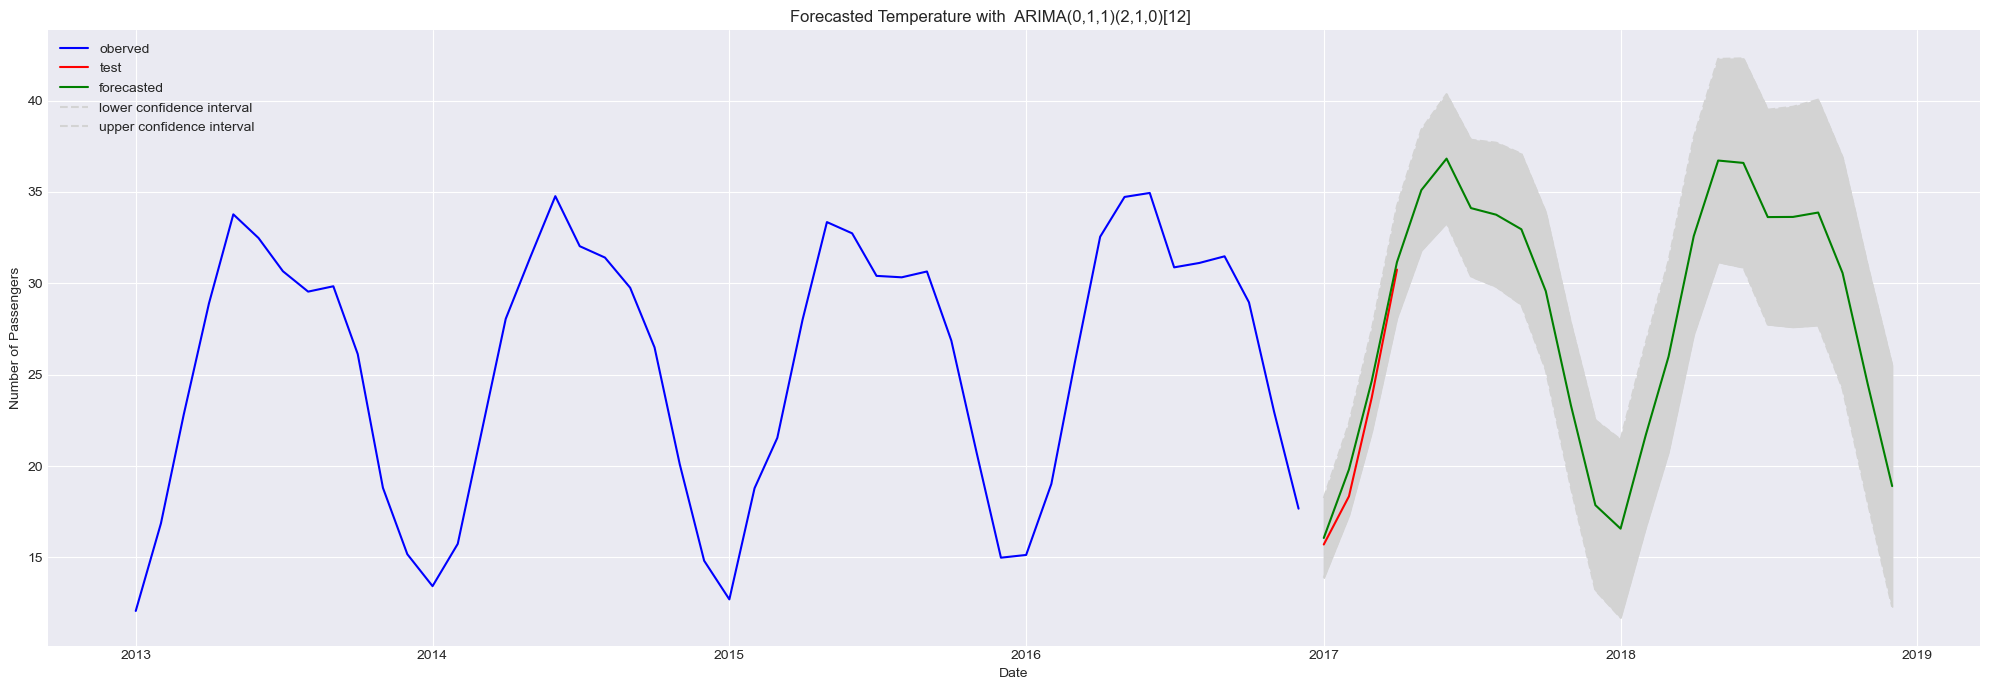

In [ ]:
fig = plt.figure(figsize=(20,7))

# OBSERVED
plt.plot(X_train.index, y_train, c='blue', label='oberved')

# TEST
plt.plot(X_test.index, y_test, c='red', label='test')

# # FORECAST
plt.plot(forecast_x_axis, forecasted, c='green', label='forecasted')
plt.plot(forecast_x_axis, lower_confidence_interval_arima, c='lightgrey', label='lower confidence interval', linestyle='dashed')
plt.plot(forecast_x_axis, upper_confidence_interval_arima, c='lightgrey', label='upper confidence interval', linestyle='dashed')


plt.fill_between(forecast_x_axis, lower_confidence_interval_arima,  upper_confidence_interval_arima, color='lightgrey')
plt.title(f"Forecasted Monthly Temperature with {monthly_model}")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.tight_layout()
plt.show()

### the model fits well the monthly data

-----------------------------

## Now let's try with weekly data

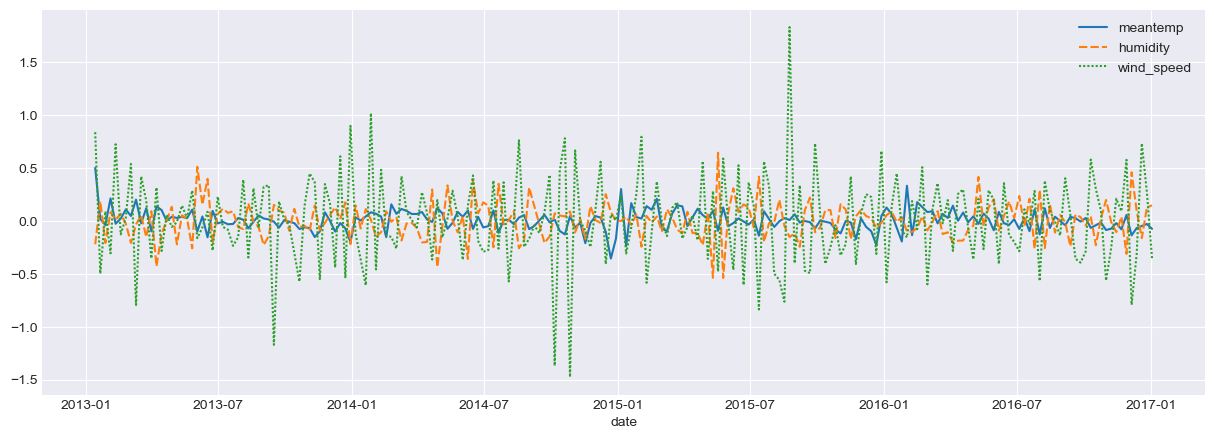

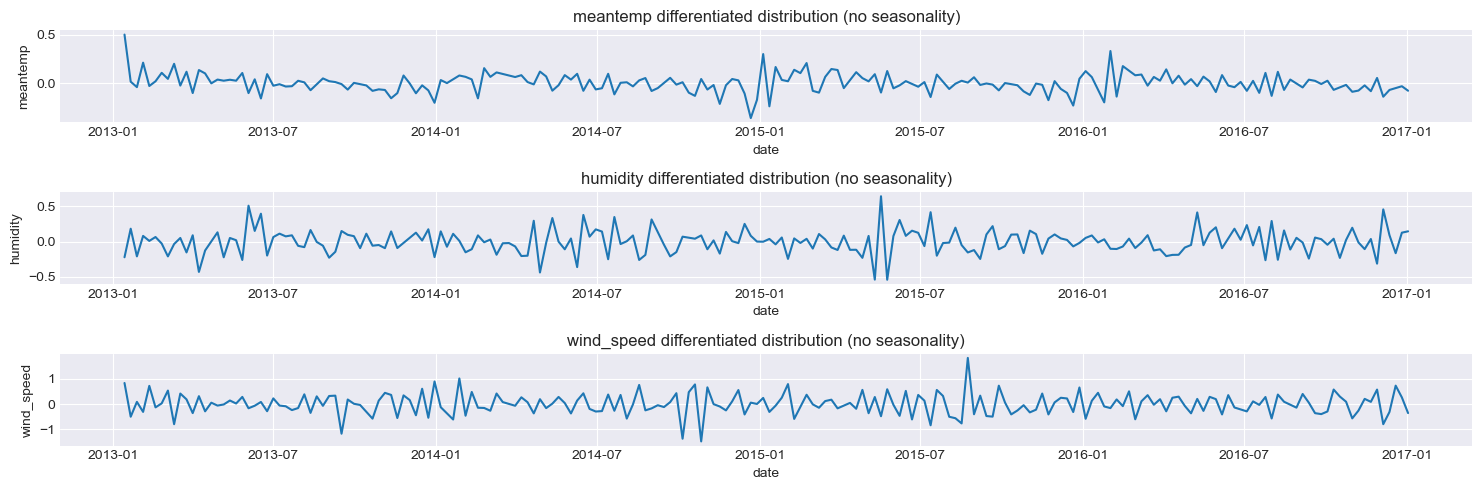

************************* ACF & PACF GRAPHS *************************


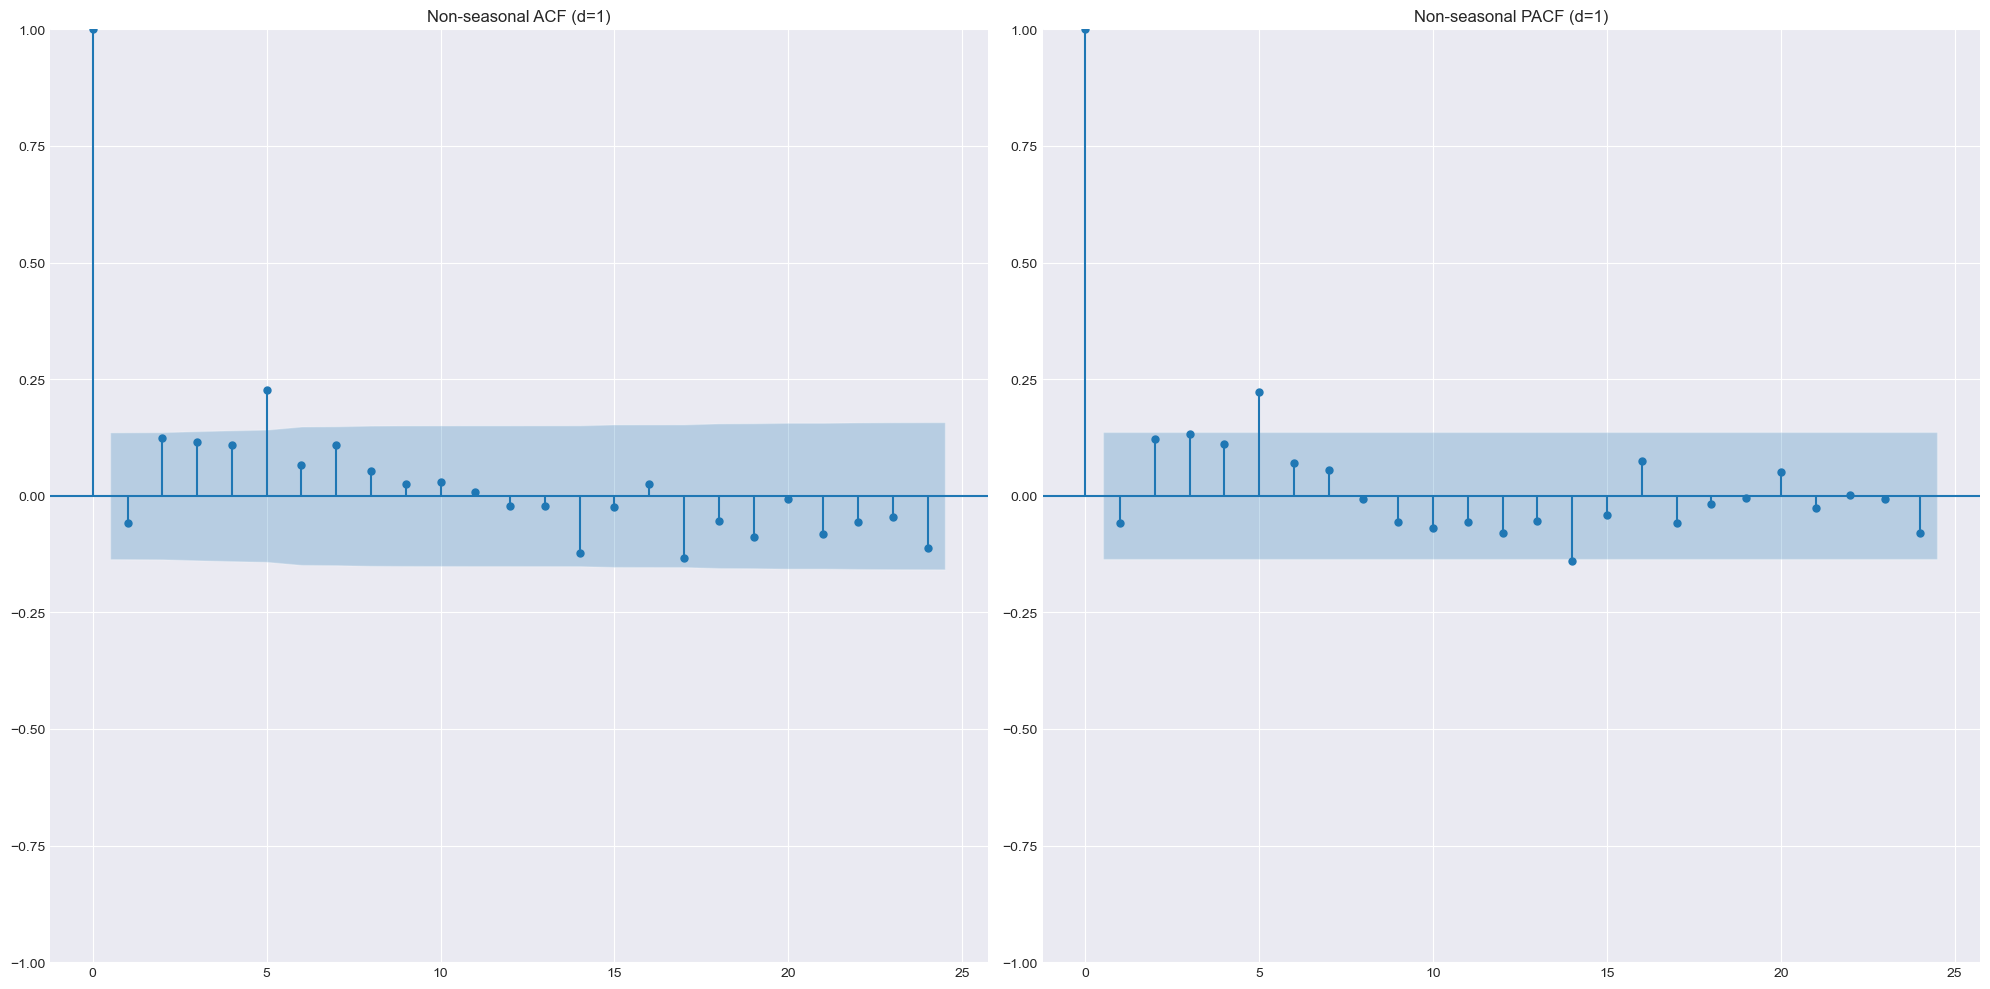

meantemp
**************************************** KPSS Test **************************************** 

 KPSS: 0.25538509380699054,
 p_value: 0.1,
 lags: 5,
 crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

The Series is Stationary - KPSS
**************************************** ADFF Test **************************************** 

 ADFF: -4.035247654856925,
 p_value: 0.001236784027331804,
 lags: 4,
 nobs: 203,
 critical values: {'1%': -3.462980134086401, '5%': -2.875885461947131, '10%': -2.5744164898444515},
 icbest: -382.74545196944405

The Series is Stationary - ADFF

humidity
**************************************** KPSS Test **************************************** 

 KPSS: 0.04553513000768846,
 p_value: 0.1,
 lags: 3,
 crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

The Series is Stationary - KPSS
**************************************** ADFF Test **************************************** 

 ADFF: -19.42738785254739,
 p_value: 0.0,
 lags: 0,
 nobs: 207,


In [199]:
check_stationarity(differenced_train_weekly_data)

In [200]:
X_train, X_test, y_train, y_test = deepcopy(train_weekly_data_grouped.drop('meantemp', axis=1)), deepcopy(test_weekly_data_grouped.drop('meantemp', axis=1)), train_weekly_data_grouped['meantemp'], test_weekly_data_grouped['meantemp']

In [201]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA


y_train.index.freq = 'W-MON'
y_test.index.freq = 'W-MON'


weekly_model = StatsForecast(
    models = [
        AutoARIMA(
            d = 1,
            start_p = 1, 
            start_q = 1,
            max_p = 5, 
            max_q = 5, 
            D = 1,
            start_P = 0, 
            season_length=52,
            seasonal = True,
            trace = True,  
            stepwise = True
        )
    ],
    freq = 'W-MON',
    n_jobs = 1       
)

y_train_df =  pd.DataFrame(y_train).reset_index().rename(columns={'meantemp': 'y', 'date': 'ds'})
y_train_df['unique_id'] = 1

weekly_model.fit(y_train_df)


ARIMA(1,1,1)(0,1,1)[52]                   :inf

ARIMA(0,1,0)(0,1,0)[52]                   :750.5217893908508

ARIMA(1,1,0)(1,1,0)[52]                   :706.3684406921213

ARIMA(0,1,1)(0,1,1)[52]                   :inf

ARIMA(1,1,0)(0,1,0)[52]                   :734.2250153024846

ARIMA(1,1,0)(1,1,1)[52]                   :inf

ARIMA(1,1,0)(0,1,1)[52]                   :inf

ARIMA(0,1,0)(1,1,0)[52]                   :707.8313983817603

ARIMA(2,1,0)(1,1,0)[52]                   :698.3273090311993

ARIMA(2,1,0)(0,1,0)[52]                   :727.1177697347931

ARIMA(2,1,0)(1,1,1)[52]                   :698.3075183463042

ARIMA(2,1,0)(0,1,1)[52]                   :inf

ARIMA(3,1,0)(1,1,1)[52]                   :690.4179585149855

ARIMA(3,1,0)(0,1,1)[52]                   :inf

ARIMA(3,1,0)(1,1,0)[52]                   :689.834517036275

ARIMA(3,1,0)(0,1,0)[52]                   :716.3004286283052

ARIMA(4,1,0)(1,1,0)[52]                   :inf

ARIMA(3,1,1)(1,1,0)[52]                   :6

StatsForecast(models=[AutoARIMA])

In [202]:
result=weekly_model.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(3, 1, 1, 0, 52, 1, 1)


In [203]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])

In [204]:
def plot_summary(residual):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,7))

    # plot[1,1]
    residual.plot(ax=axs[0,0])
    axs[0,0].set_title("Residuals")

    # plot
    sns.distplot(residual, ax=axs[0,1])
    axs[0,1].set_title("Density plot - Residual")

    # plot
    stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
    axs[1,0].set_title('Plot Q-Q')

    # plot
    plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
    axs[1,1].set_title("Autocorrelation")

    plt.show()

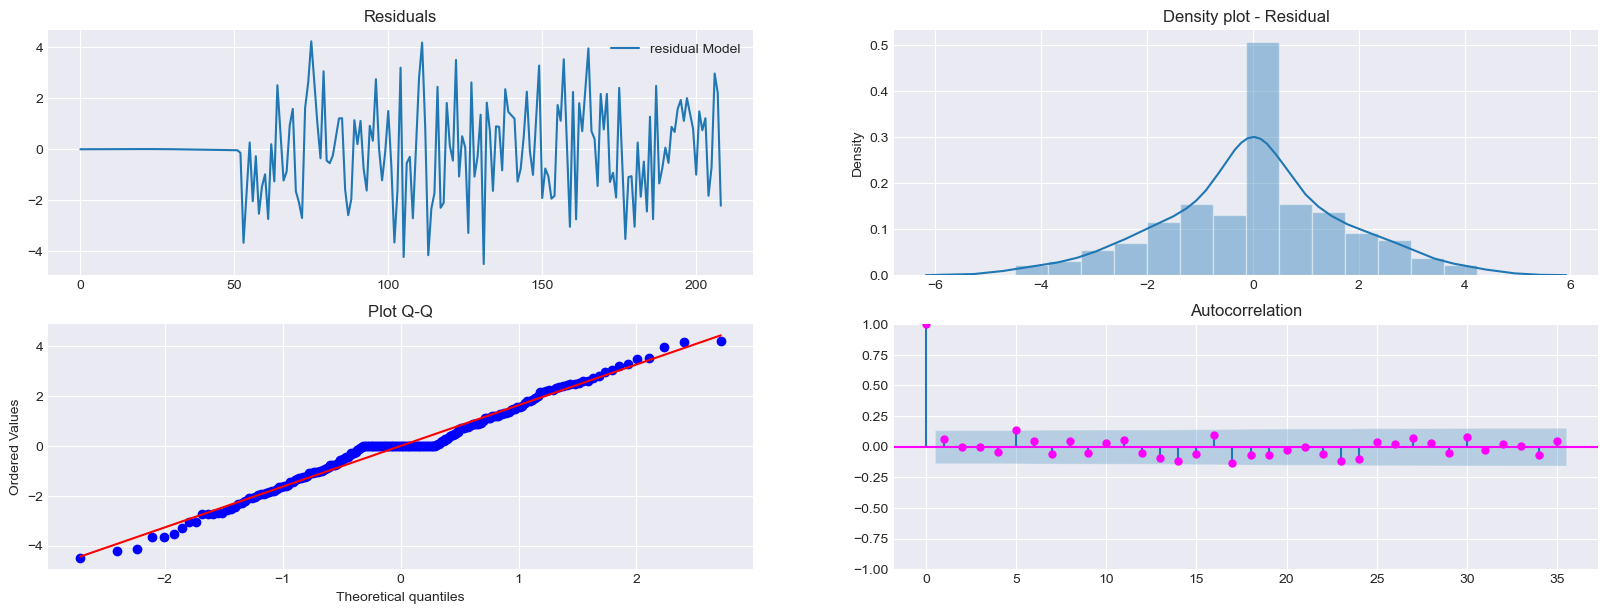

In [205]:
plot_summary(residual)

In [206]:
def test_statistics(residual, m):

    from scipy.stats import jarque_bera, skew, kurtosis
    from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
    import statsmodels.api as sm

    # Ljung-Box test (autocorrelation)
    ljungbox_results = acorr_ljungbox(residual, lags=[10], return_df=True)

    # Jarque-Bera test (normality)
    jb_stat, jb_pvalue = jarque_bera(residual)

    # ARCH LM Test for heteroskedasticity
    arch_test = het_arch(residual, nlags=m)
    arch_stat, arch_pvalue = arch_test[:2]

    # Skewness and Kurtosis
    resid_skewness = skew(residual)
    resid_kurtosis = kurtosis(residual, fisher=False)  # Fisher's kurtosis (excess kurtosis)

    # Create test results table
    test_table = pd.DataFrame({
        'Test': [
            'Ljung-Box (lag=52)',
            'Jarque-Bera',
            f'Heteroskedasticity (ARCH LM, lag={m})',
            'Skewness',
            'Kurtosis'
        ],
        'Statistic': [
            ljungbox_results['lb_stat'].iloc[0],
            jb_stat,
            arch_stat,
            resid_skewness,
            resid_kurtosis
        ],
        'p-value': [
            ljungbox_results['lb_pvalue'].iloc[0],
            jb_pvalue,
            arch_pvalue,
            np.nan,  # Skewness does not have a direct p-value
            np.nan   # Kurtosis does not have a direct p-value
        ]
    })


    return test_table

In [207]:
test_statistics(residual, 52)

Test                Statistic   p-value
0                    Ljung-Box (lag=52)                 7.755604  0.652695
1                           Jarque-Bera                 0.537939  0.764167
2  Heteroskedasticity (ARCH LM, lag=52)                48.002363  0.631815
3                              Skewness  [-0.052477977581033015]       NaN
4                              Kurtosis      [3.225293377804627]       NaN

In [235]:
forecasts = weekly_model.forecast(df=y_train_df, h= len(X_test) + 87, fitted=True, level=[95])

forecasted = forecasts['AutoARIMA']
lower_confidence_interval_arima = forecasts['AutoARIMA-lo-95']
upper_confidence_interval_arima = forecasts['AutoARIMA-hi-95']

start = forecasts['ds'].iloc[0]
end = forecasts['ds'].iloc[-1]

from dateutil.relativedelta  import relativedelta

test_first_date = X_test.index[0]

end_of_prediction = test_first_date + relativedelta(weeks=+ 103)

forecast_x_axis = pd.date_range(start=start, end=end, freq='W-MON')


ARIMA(1,1,1)(0,1,1)[52]                   :inf

ARIMA(0,1,0)(0,1,0)[52]                   :750.5217893908508

ARIMA(1,1,0)(1,1,0)[52]                   :706.3684406921213

ARIMA(0,1,1)(0,1,1)[52]                   :inf

ARIMA(1,1,0)(0,1,0)[52]                   :734.2250153024846

ARIMA(1,1,0)(1,1,1)[52]                   :inf

ARIMA(1,1,0)(0,1,1)[52]                   :inf

ARIMA(0,1,0)(1,1,0)[52]                   :707.8313983817603

ARIMA(2,1,0)(1,1,0)[52]                   :698.3273090311993

ARIMA(2,1,0)(0,1,0)[52]                   :727.1177697347931

ARIMA(2,1,0)(1,1,1)[52]                   :698.3075183463042

ARIMA(2,1,0)(0,1,1)[52]                   :inf

ARIMA(3,1,0)(1,1,1)[52]                   :690.4179585149855

ARIMA(3,1,0)(0,1,1)[52]                   :inf

ARIMA(3,1,0)(1,1,0)[52]                   :689.834517036275

ARIMA(3,1,0)(0,1,0)[52]                   :716.3004286283052

ARIMA(4,1,0)(1,1,0)[52]                   :inf

ARIMA(3,1,1)(1,1,0)[52]                   :6

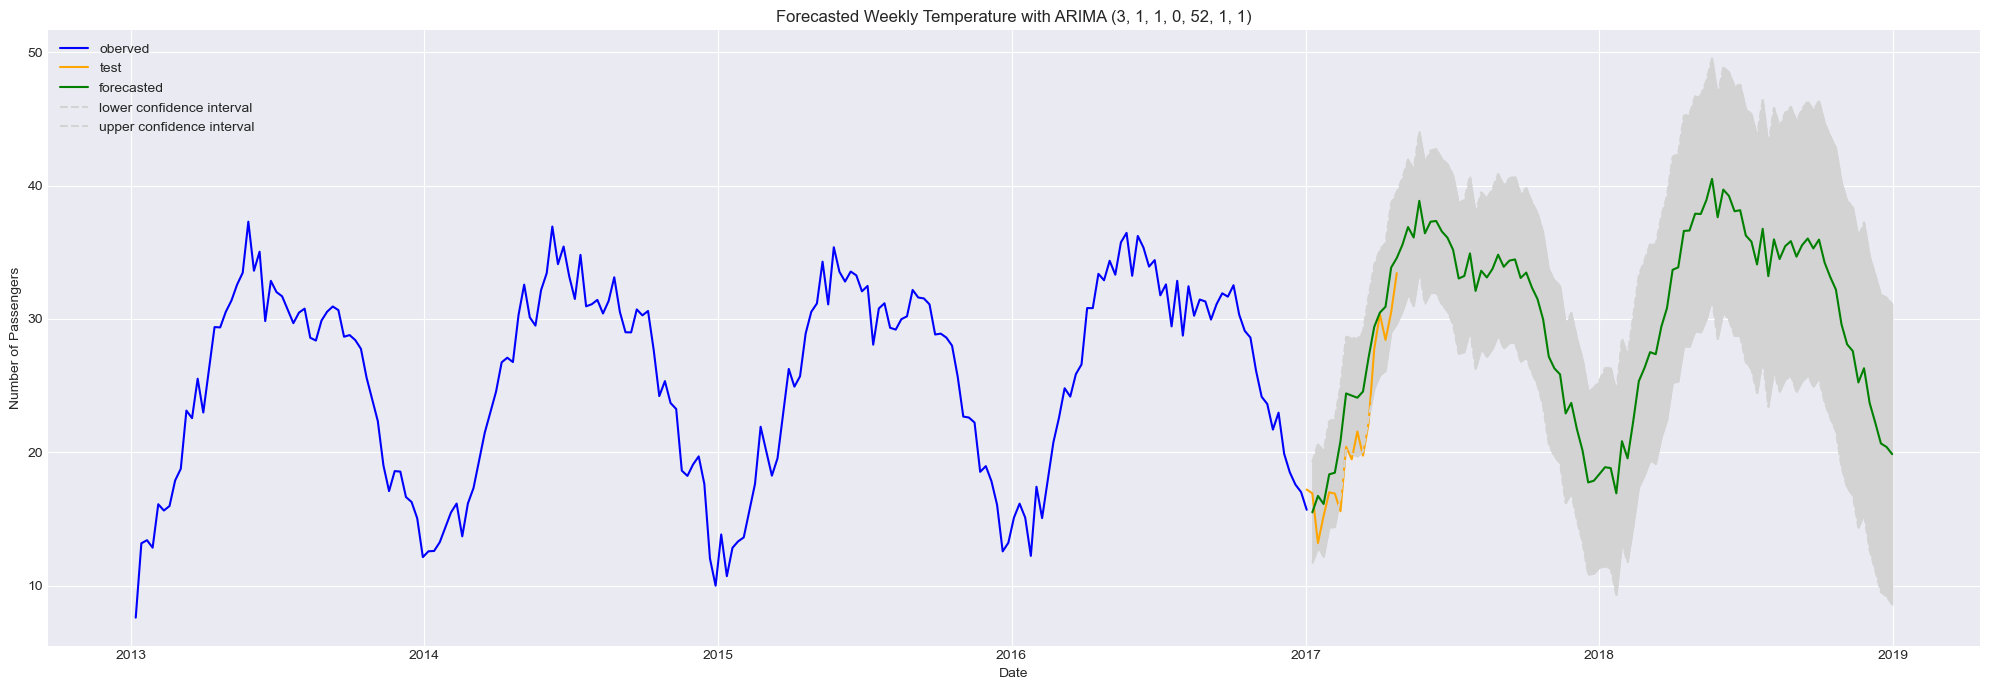

In [236]:
fig = plt.figure(figsize=(20,7))

# OBSERVED
plt.plot(X_train.index, y_train, c='blue', label='oberved')

# TEST
plt.plot(X_test.index, y_test, c='orange', label='test')

# # FORECAST
plt.plot(forecast_x_axis, forecasted, c='green', label='forecasted')
plt.plot(forecast_x_axis, lower_confidence_interval_arima, c='lightgrey', label='lower confidence interval', linestyle='dashed')
plt.plot(forecast_x_axis, upper_confidence_interval_arima, c='lightgrey', label='upper confidence interval', linestyle='dashed')


plt.fill_between(forecast_x_axis, lower_confidence_interval_arima,  upper_confidence_interval_arima, color='lightgrey')
plt.title(f"Forecasted Weekly Temperature with ARIMA {result['arma']}")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.tight_layout()
plt.show()